<User username:jroebuck>
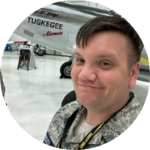

In [1]:
import arcgis
gis = arcgis.GIS(profile="your_demo_profile")
gis.users.me

In [2]:
#### Let's import some new users from CSV:

In [3]:
import uuid
# username,password,name,email,description,is_admin
# add a suffix to each username, for this demo just adding a unique suffix
username_suffix = f"_{uuid.uuid4().hex[-5:]}"
# generates a unique password for each user in the CSV
new_users_csv = f"""
username,password,first_name,last_name,email,description,is_admin
jcommander{username_suffix},{uuid.uuid4().hex + uuid.uuid4().hex.upper()}!,Joel,Commander,jcommander@roebuck.edu,Cadet Commander,1
asergeant{username_suffix},{uuid.uuid4().hex + uuid.uuid4().hex.upper()}!,Alaphant,Sergeant,asergeant@roebuck.edu,Cadet First Sergeant,1
bsergeant{username_suffix},{uuid.uuid4().hex + uuid.uuid4().hex.upper()}!,Bravado,Sergeant,bsergeant@roebuck.edu,Bravo Sergeant,0
"""

In [4]:
import pandas as pd
from io import StringIO

# emulate a file from this csv string
new_users_csv_io = StringIO(new_users_csv)
# read csv into a Pandas DataFrame
new_users_df = pd.read_csv(new_users_csv_io)
# display the dataframe
new_users_df

,username,password,first_name,last_name,email,description,is_admin
0,jcommander_d678d,424fb15bfa704c219d22160df38d5a669A59054D2C2F49...,Joel,Commander,jcommander@roebuck.edu,Cadet Commander,1
1,asergeant_d678d,23b1261e52384b09849c764bf44b167aFCC28658F7D94B...,Alaphant,Sergeant,asergeant@roebuck.edu,Cadet First Sergeant,1
2,bsergeant_d678d,9c5303622fe045d78fe4a308d1dab8ff5C37A86CEAB649...,Bravado,Sergeant,bsergeant@roebuck.edu,Bravo Sergeant,0


In [5]:
for idx, user in new_users_df.iterrows():
    print(f"Creating user #{idx + 1}: {user['username']}")
    # use a built-in role, admin or user
    user_role = "org_admin" if user['is_admin'] else "org_user"
    # select license based on admin
    # you could parameterize this in other ways in your input CSV
    user_type = "GISProfessionalAdvUT" if user['is_admin'] else "GISProfessionalStdUT"
    result = gis.users.create(username=user['username'],
                              password=user['password'],
                              firstname=user['first_name'],
                              lastname=user['last_name'],
                              email=user['email'],
                              user_type=user_type,
                              role=user_role)
    result_msg = f"Created user: {user['username']}" if result else f"Failed to create user: {user['username']}"
    print(result_msg)

Creating user #1: jcommander_d678d
Created user: jcommander_d678d
Creating user #2: asergeant_d678d
Created user: asergeant_d678d
Creating user #3: bsergeant_d678d
Created user: bsergeant_d678d


In [6]:
# Alright, we have created a few users from a spreadsheet

In [ ]:
# Now let's add them to a group!

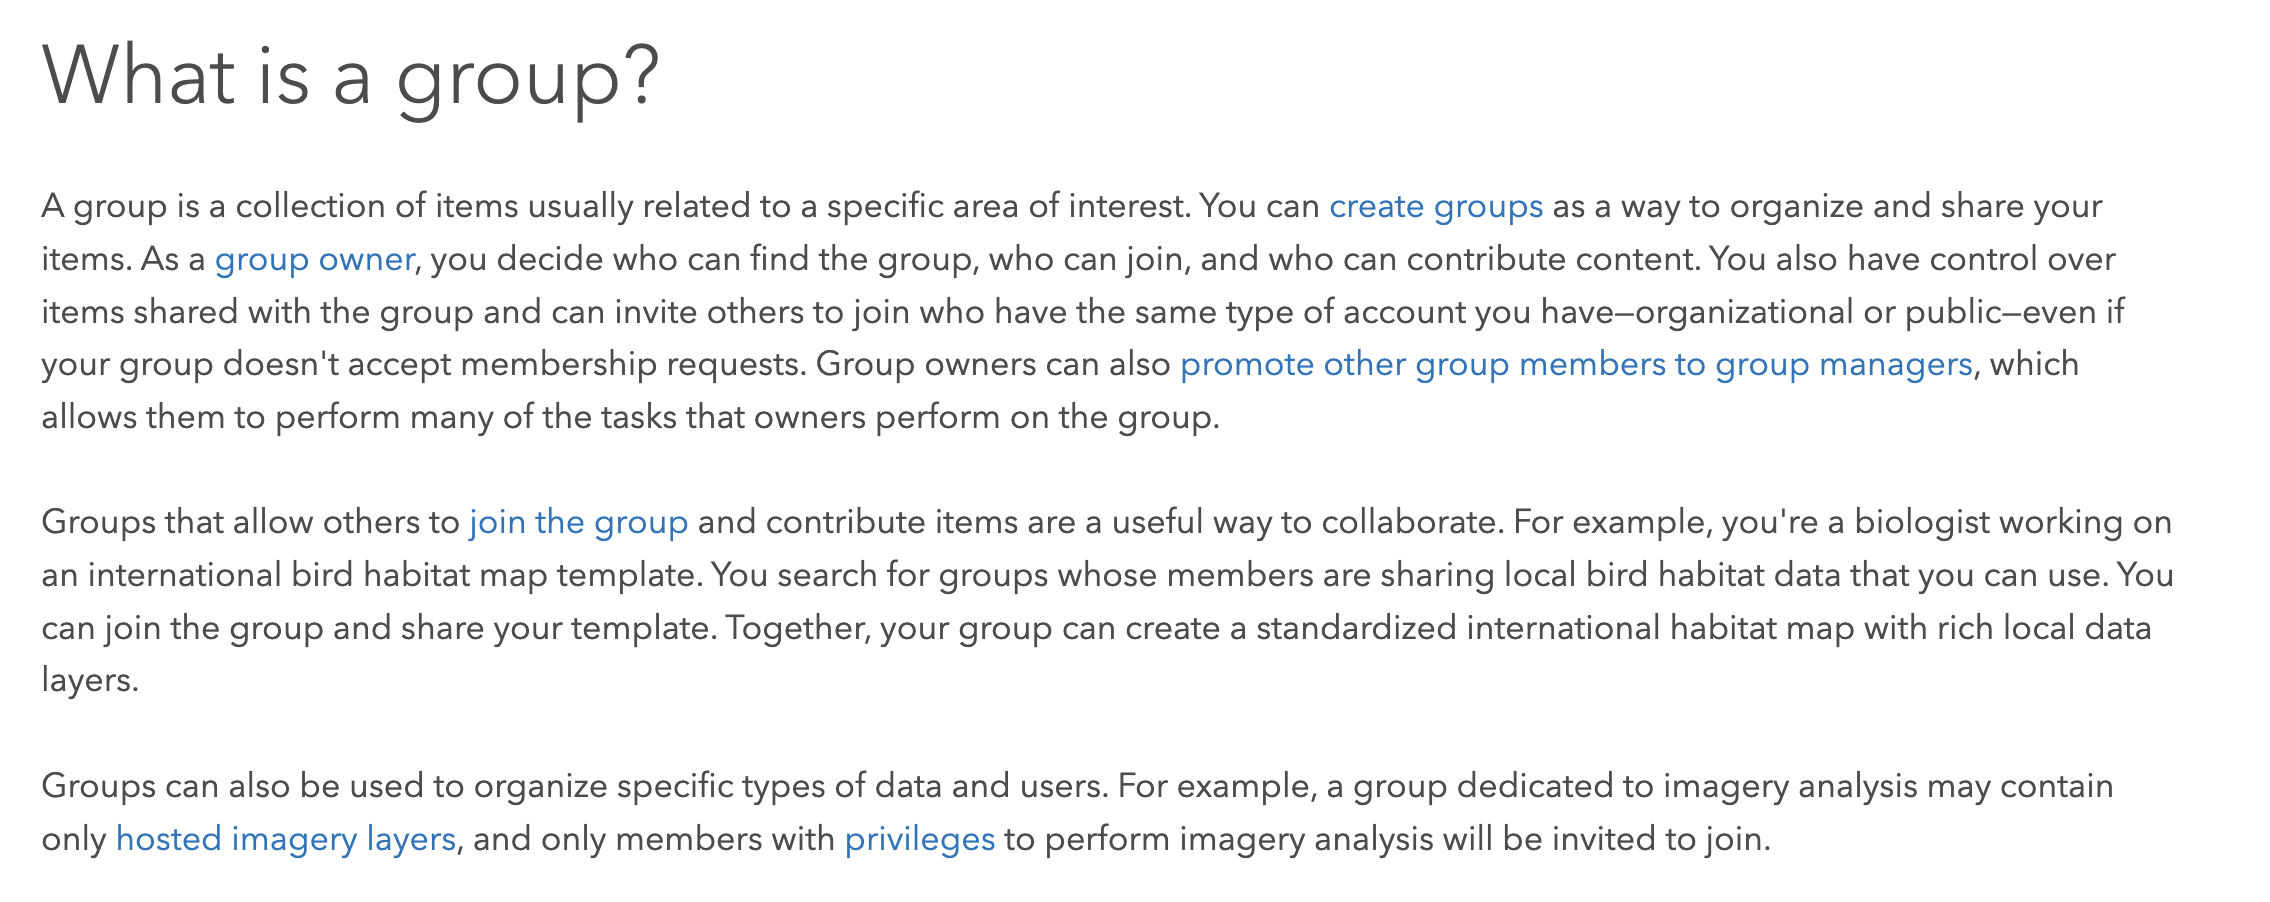

### TLDR: Groups make it easy to share relevant maps and data with certain _groups_ of users

In [7]:
# get groups, with title as the key
# Query returns values inclusively: in this case we're really looking for
# DTS25 and DTS25_Admin -- so we can just query for DTS25 and get both
# Then we'll use pythonic syntax to make it a dictionary
groups = {group.title: group for group in gis.groups.search(f'title:DTS25')}
groups
    

{'DTS25': <Group title:"DTS25" owner:jroebuck>,
 'DTS25_Admin': <Group title:"DTS25_Admin" owner:jroebuck>}

In [8]:
for idx, user in new_users_df.iterrows():
    # pick group name based on if user is an admin
    group_name = "DTS25_Admin" if user['is_admin'] else "DTS25"
    print(f"Adding user: {user['username']} to group: {group_name}")
    result = groups[group_name].add_users([user['username']])
    result_msg = f"Added user: {user['username']} to group" if not result['notAdded'] else f"Failed to add user to group"

Adding user: jcommander_d678d to group: DTS25_Admin
Adding user: asergeant_d678d to group: DTS25_Admin
Adding user: bsergeant_d678d to group: DTS25


In [ ]:
# We have added these new users to groups; admins to DTS25_Admin and non-admins to DTS25

In [ ]:
# Next let's revisit Roles

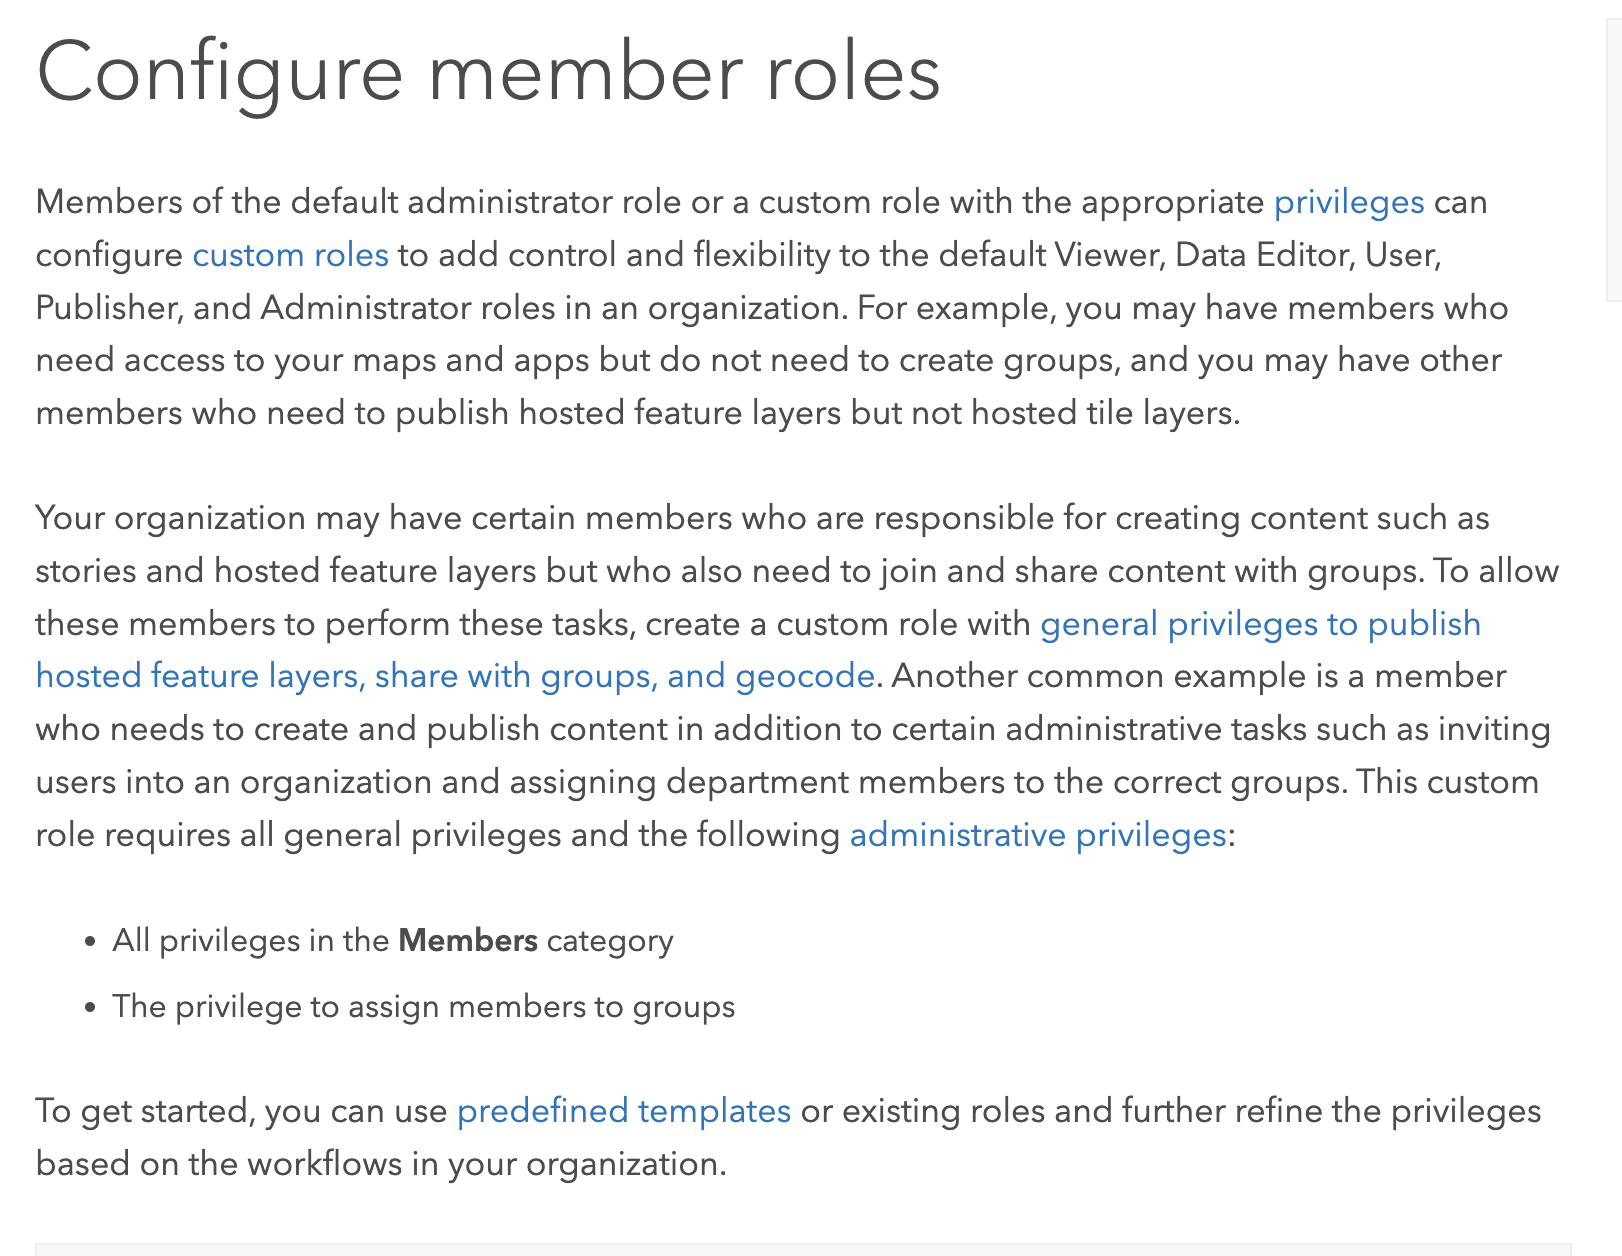

### TLDR: there are built-in roles that work for many situations; in some cases you may want to refine system permissions more finely -- creating custom roles is a great tool for this!

In [ ]:
# The org_admin role works well for us for admins, but non-admins may need more permissions than org_user provides

In [ ]:
# Let's create a custom role and reassign non-admins to it

In [9]:
elevated_user_role = gis.users.roles.get_role("elevated_user")
elevated_user_role

<Role name: elevated_user, description: elevated_user>

In [10]:
for idx, user in new_users_df.query("is_admin == False").iterrows():
    g = gis.users.get(user['username']).update_role(elevated_user_role)
    g
g

True